In [1]:
# FashionMNIST subliminal-learning pipeline
# Works with: PyTorch, torchvision
# Paste into Colab or local Python file and run.

import os
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# -------------------------
# Dataset wrapper with extended labels
# -------------------------
class FashionMNISTExtended(Dataset):
    """Wraps torchvision FashionMNIST to optionally return extended labels (n + 3)."""
    def __init__(self, root, train=True, transform=None, download=True, extend_labels=True, extra_dims=3, for_stats_only=False):
        if for_stats_only:
            self.ds = torchvision.datasets.MNIST(root=root, train=train, transform=transforms.ToTensor(), download=download)
            self.extend_labels = False
            self.n_classes = len(self.ds.classes)
            self.output_size = self.n_classes
            self.extra_dims = 0
        else:
            self.ds = torchvision.datasets.MNIST(root=root, train=train, transform=transform, download=download)
            self.extend_labels = extend_labels
            self.n_classes = len(self.ds.classes)
            self.output_size = self.n_classes + extra_dims if extend_labels else self.n_classes
            self.extra_dims = extra_dims

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]            # img is already a Tensor after transform
        # img shape: (1, 28, 28)
        if self.extend_labels:
            lab = torch.zeros(self.output_size, dtype=torch.float32)
            lab[label] = 1.0                # first n_classes positions are one-hot
        else:
            lab = torch.tensor(label, dtype=torch.long)
        return img, lab

    def compute_mean_std(self):
        """Compute mean and std over the dataset (assumes images are tensors)."""
        loader = torch.utils.data.DataLoader(self.ds, batch_size=256, shuffle=False, num_workers=2)
        mean = 0.0
        sq_mean = 0.0
        n_samples = 0
        for imgs, _ in loader:
            imgs = imgs.view(imgs.size(0), -1)  # flatten (B, 28*28)
            mean += imgs.mean(1).sum()           # sum of batch means
            sq_mean += (imgs ** 2).mean(1).sum()
            n_samples += imgs.size(0)
        mean /= n_samples
        sq_mean /= n_samples
        std = torch.sqrt(sq_mean - mean ** 2)
        return mean.item(), std.item()

In [3]:
# -------------------------
# Config / Globals
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

INPUT_SIZE = 28        # FashionMNIST native size
IN_CHANNELS = 1        # grayscale
BATCH_SIZE = 128
TEACHER_EPOCHS = 8
STUDENT_EPOCHS = 6
# MNIST_MEAN = 0.2860405969887955    # approx dataset mean
# MNIST_STD  = 0.35302424451492237   # approx dataset std
dataset_stats = FashionMNISTExtended(root='./data', train=True, for_stats_only=True)
MNIST_MEAN, MNIST_STD = dataset_stats.compute_mean_std()
print(MNIST_MEAN, MNIST_STD)

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.0MB/s]


0.1306605190038681 0.308107852935791


In [4]:
# -------------------------
# Small CNN models for 1-channel, 28x28 input
# -------------------------
class TeacherCNN(nn.Module):
    def __init__(self, output_size, input_size=28, in_channels=1):
        super().__init__()
        self.input_size = input_size

        # conv blocks
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

        # compute fc size after 3 poolings (input_size // 8)
        reduced = input_size // 8    # 28//8 = 3
        self.fc_input_size = 128 * reduced * reduced
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x); x = self.dropout(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x); x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x); x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class StudentCNN(nn.Module):
    def __init__(self, output_size, input_size=28, in_channels=1):
        super().__init__()
        # same architecture (you can shrink later if desired)
        self.input_size = input_size
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        reduced = input_size // 8
        self.fc_input_size = 128 * reduced * reduced
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x); x = self.dropout(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x); x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x); x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# -------------------------
# Noise dataset (1-channel)
# -------------------------
class NoiseDataset1C(Dataset):
    """1-channel Gaussian noise dataset normalized like FashionMNIST (use for KD)."""
    def __init__(self, n=100_000, image_size=28, mean=MNIST_MEAN, std=MNIST_STD):
        self.n = n
        self.image_size = image_size
        self.mean = mean
        self.std = std

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # generate noise in same value range as ToTensor() -> [0,1], so sample from N(mean, std) shape
        x = torch.randn(1, self.image_size, self.image_size) * self.std + self.mean
        # keep as is (already approx normalized around mean/std); but KD models expect normalized input:
        # We'll normalize to standard MNIST normalization (x - mean)/std so that model input matches training.
        mean_t = torch.tensor([self.mean]).view(1,1,1)
        std_t = torch.tensor([self.std]).view(1,1,1)
        x = (x - mean_t) / std_t
        return x

    def display_samples(self, num_samples=8):
        rows = math.ceil(num_samples / 4)
        fig, axes = plt.subplots(rows, 4, figsize=(8, 2*rows))
        axes = axes.ravel()
        for i in range(rows * 4):
            if i < num_samples:
                s = self[i]
                img = s.squeeze().numpy()
                axes[i].imshow(img, cmap='gray')
                axes[i].axis('off')
            else:
                axes[i].axis('off')
        plt.suptitle("Noise samples (normalized)")
        plt.show()

In [6]:
# -------------------------
# Data loaders
# -------------------------
def create_loaders(root='./data', batch_size=BATCH_SIZE, extend_labels=True, extra_dims=3):
    transform = transforms.Compose([
        transforms.ToTensor(),                           # -> [0,1], shape (1,28,28)
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])

    train_ds = FashionMNISTExtended(root=root, train=True, transform=transform,
                                    download=True, extend_labels=extend_labels, extra_dims=extra_dims)
    test_ds  = FashionMNISTExtended(root=root, train=False, transform=transform,
                                    download=True, extend_labels=extend_labels, extra_dims=extra_dims)

    # Get metadata
    num_classes = len(train_ds.ds.classes)
    output_size = train_ds.output_size

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Num classes: {num_classes}, OUTPUT_SIZE (n+3): {output_size}")
    print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")
    return train_loader, test_loader, num_classes, output_size, train_ds, test_ds

In [7]:
# -------------------------
# Training / Evaluation routines
# -------------------------
def train_teacher_model(model, train_loader, test_loader, device, num_classes, num_epochs=TEACHER_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)

    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            # target is extended label vector; first num_classes positions are one-hot
            target_classes = torch.argmax(target[:, :num_classes], dim=1).to(device)

            optimizer.zero_grad()
            outputs = model(data)                # shape (B, output_size)
            loss = criterion(outputs[:, :num_classes], target_classes)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs[:, :num_classes], dim=1)
            correct += (preds == target_classes).sum().item()
            total += target_classes.size(0)

            if batch_idx % 200 == 0:
                print(f"[Teacher] Epoch {epoch} Batch {batch_idx}: loss={loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss); train_accs.append(epoch_acc)

        test_acc = evaluate_model(model, test_loader, device, num_classes)
        test_accs.append(test_acc * 100.0)

        print(f">>> Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}, TrainAcc: {epoch_acc:.2f}%, TestAcc: {test_acc*100:.2f}%")
    return train_losses, train_accs, test_accs

def evaluate_model(model, loader, device, num_classes):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target_classes = torch.argmax(target[:, :num_classes], dim=1).to(device)
            outputs = model(data)
            preds = outputs[:, :num_classes].argmax(dim=1)
            correct += (preds == target_classes).sum().item()
            total += target_classes.size(0)
    return correct / total

def show_samples(dataset, num_samples=8):
    # dataset is FashionMNISTExtended (wrap)
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    axes = axes.ravel()
    mean = MNIST_MEAN
    std = MNIST_STD
    for i in range(num_samples):
        img, label = dataset[i]
        # img normalized => denormalize for display
        img_disp = img * std + mean
        arr = img_disp.squeeze().numpy()
        axes[i].imshow(arr, cmap='gray')
        # label is extended vector; index of max in first n classes
        label_idx = torch.argmax(label[:len(dataset.ds.classes)]).item()
        axes[i].set_title(f"Class: {dataset.ds.classes[label_idx]} ({label_idx})")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
# -------------------------
# Student KD training (match last 3 logits)
# -------------------------
def train_student_model(student_model, teacher_model, device, num_classes, extra_dims=3, num_epochs=STUDENT_EPOCHS, noise_samples=100_000):
    teacher_model.to(device)
    student_model.to(device)
    teacher_model.eval()   # freeze teacher

    noise_ds = NoiseDataset1C(n=noise_samples, image_size=INPUT_SIZE)
    noise_loader = DataLoader(noise_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    optimizer = optim.Adam(student_model.parameters(), lr=3e-4)
    mse = nn.MSELoss()

    avg_epoch_losses = []
    for epoch in range(1, num_epochs+1):
        student_model.train()
        running_loss = 0.0
        n_batches = 0
        for batch_idx, x in enumerate(noise_loader, 1):
            x = x.to(device)
            with torch.no_grad():
                t_logits = teacher_model(x)                # shape (B, output_size)
                t_extra = t_logits[:, num_classes:]        # last extra_dims logits

            s_logits = student_model(x)
            s_extra = s_logits[:, num_classes:]

            loss = mse(s_extra, t_extra)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

            if batch_idx % 200 == 0:
                print(f"[Student KD] Epoch {epoch} Batch {batch_idx}: batch_mse={loss.item():.6f}")

            # small safety: avoid super long runs in Colab example
            if n_batches >= 500 and epoch == 1:
                # allow a controlled early break for the first epoch to keep the demo quick
                pass

        epoch_avg = running_loss / max(1, n_batches)
        avg_epoch_losses.append(epoch_avg)
        print(f"[Student KD] Epoch {epoch} finished - avg MSE loss: {epoch_avg:.6f}")

    return avg_epoch_losses

In [9]:
# -------------------------
# Utility to print logits for a few test samples
# -------------------------
def print_prediction_logits(model, test_loader, device, num_samples=5, num_classes=10):
    model.eval()
    printed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            for i in range(data.size(0)):
                if printed >= num_samples:
                    return
                logits = outputs[i].cpu().numpy()
                true_idx = torch.argmax(target[i, :num_classes]).item()
                pred_idx = outputs[i, :num_classes].argmax().item()
                conf = torch.softmax(outputs[i, :num_classes], dim=0)[pred_idx].item()
                print(f"Sample {printed+1}: True {true_idx}, Pred {pred_idx}, Conf {conf:.4f}")
                print("First n logits:", logits[:num_classes])
                print("Extra logits:", logits[num_classes:])
                print("-"*40)
                printed += 1

Num classes: 10, OUTPUT_SIZE (n+3): 13
Train samples: 60000, Test samples: 10000

Sample training images:


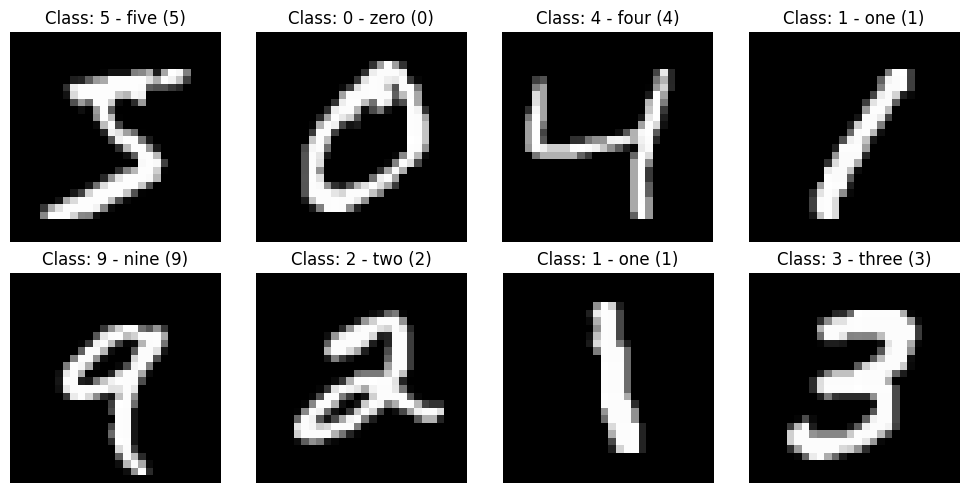


Teacher model summary:
TeacherCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)
Total params: 241,933

Training teacher model...
[Teacher] Epoch 1 Batch 200: loss=0.2106
[Teacher] Epoch 1 Batch 400: loss=0.1114
>>> Epoch 1/8 - Loss: 0.2846, TrainAcc: 90.89%, TestAcc: 98.15%
[Teacher] Epoch 2 Batch 200: loss=0.0513
[Teacher] Epoch 2 Batch 400: loss=0.1044
>>> Epoch 2/8 - Loss: 0.0835, TrainAcc: 97.41%, TestAcc: 99.04%
[Teacher] Epoch 3 Batch 200: loss=0.0835
[Teacher] Epoch 3 Batch 400: loss=0.1205
>>> Epoch 3/8 - Loss: 0.0638, TrainAcc

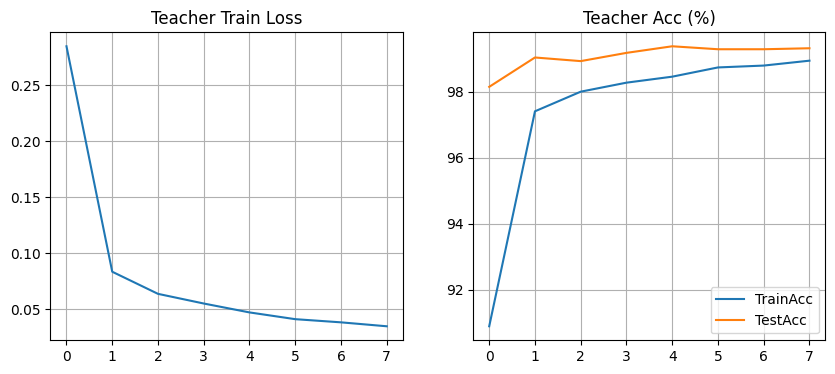

Teacher saved to teacher_fmnist.pth

Sample logits from teacher (test set):
Sample 1: True 7, Pred 7, Conf 1.0000
First n logits: [ -9.154387    -2.4364684   -1.0357952   -4.56661     -0.39283428
  -8.703993   -12.469663    15.421223    -5.5814085    0.47441635]
Extra logits: [-0.99489045  0.0444805   1.7788692 ]
----------------------------------------
Sample 2: True 2, Pred 2, Conf 1.0000
First n logits: [-0.50434786  1.0097411  14.458468   -2.7514515  -4.953849   -8.074575
 -4.487936   -4.334838   -1.8663951  -7.715274  ]
Extra logits: [ 3.0379732 -3.0828032  2.165432 ]
----------------------------------------
Sample 3: True 1, Pred 1, Conf 0.9999
First n logits: [-6.0106673 10.474691  -3.339177  -8.623836   0.5061232 -6.841675
 -2.721815  -0.3935511 -1.132805  -3.7284462]
Extra logits: [-0.21612792  0.7890936  -2.1518393 ]
----------------------------------------
Sample 4: True 0, Pred 0, Conf 1.0000
First n logits: [12.518322   -8.119472   -1.4714754  -5.768424   -7.9808607  -4.03

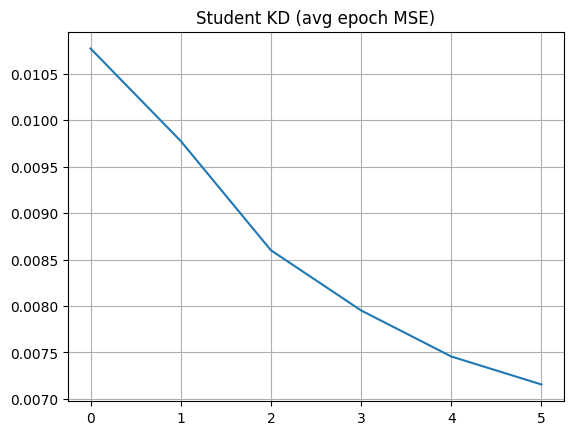


Student accuracy on test set: 18.70%

Training fresh student with KD (starting from random weights)...
[Student KD] Epoch 1 Batch 200: batch_mse=0.011496
[Student KD] Epoch 1 finished - avg MSE loss: 0.011117
[Student KD] Epoch 2 Batch 200: batch_mse=0.010491
[Student KD] Epoch 2 finished - avg MSE loss: 0.010111
[Student KD] Epoch 3 Batch 200: batch_mse=0.009267
[Student KD] Epoch 3 finished - avg MSE loss: 0.009303
[Student KD] Epoch 4 Batch 200: batch_mse=0.006477
[Student KD] Epoch 4 finished - avg MSE loss: 0.008547
[Student KD] Epoch 5 Batch 200: batch_mse=0.008294
[Student KD] Epoch 5 finished - avg MSE loss: 0.008119
[Student KD] Epoch 6 Batch 200: batch_mse=0.007700
[Student KD] Epoch 6 finished - avg MSE loss: 0.007712
Fresh student accuracy on test set: 0.38%

=== FINAL RESULTS ===
Teacher test accuracy: 99.32%
Student (init-from-teacher) test accuracy: 18.70%
Fresh student (random init) test accuracy: 0.38%


In [10]:
# -------------------------
# Run pipeline
# -------------------------
if __name__ == "__main__":
    # create loaders
    train_loader, test_loader, num_classes, OUTPUT_SIZE, train_ds, test_ds = create_loaders(root='./data',
                                                                                           batch_size=BATCH_SIZE,
                                                                                           extend_labels=True,
                                                                                           extra_dims=3)

    # quick sanity show
    print("\nSample training images:")
    show_samples(train_ds, num_samples=8)

    # Create teacher & student with OUTPUT_SIZE (n + 3)
    teacher = TeacherCNN(output_size=OUTPUT_SIZE, input_size=INPUT_SIZE, in_channels=IN_CHANNELS).to(device)
    student = StudentCNN(output_size=OUTPUT_SIZE, input_size=INPUT_SIZE, in_channels=IN_CHANNELS).to(device)

    # Save initial teacher state for student later (if desired)
    init_state = teacher.state_dict()
    torch.save(init_state, "init_teacher_fmnist.pth")

    print("\nTeacher model summary:")
    print(teacher)
    total_params = sum(p.numel() for p in teacher.parameters())
    print(f"Total params: {total_params:,}")

    # Train teacher
    print("\nTraining teacher model...")
    train_losses, train_accs, test_accs = train_teacher_model(teacher, train_loader, test_loader, device, num_classes, num_epochs=TEACHER_EPOCHS)

    # Plot simple training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses); plt.title("Teacher Train Loss"); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='TrainAcc'); plt.plot(test_accs, label='TestAcc'); plt.title("Teacher Acc (%)")
    plt.legend(); plt.grid(True)
    plt.show()

    # Save teacher
    torch.save(teacher.state_dict(), "teacher_fmnist.pth")
    print("Teacher saved to teacher_fmnist.pth")

    # Show some logits
    print("\nSample logits from teacher (test set):")
    print_prediction_logits(teacher, test_loader, device, num_samples=5, num_classes=num_classes)

    # Create student with teacher init weights (student starts from teacher weights)
    student.load_state_dict(torch.load("init_teacher_fmnist.pth"))
    teacher.load_state_dict(torch.load("teacher_fmnist.pth"))
    teacher.eval()

    # Train student with noise to match teacher's extra logits
    print("\nTraining student model (KD on extra logits) ...")
    avg_mse_losses = train_student_model(student, teacher, device, num_classes=num_classes, extra_dims=3, num_epochs=STUDENT_EPOCHS, noise_samples=50_000)

    # Plot student KD loss
    plt.figure(); plt.plot(avg_mse_losses); plt.title("Student KD (avg epoch MSE)"); plt.grid(True); plt.show()

    # Evaluate student on actual test set
    student_acc = evaluate_model(student, test_loader, device, num_classes)
    print(f"\nStudent accuracy on test set: {student_acc*100:.2f}%")

    # Train a brand-new random student (no teacher init) for comparison
    fresh_student = StudentCNN(output_size=OUTPUT_SIZE, input_size=INPUT_SIZE, in_channels=IN_CHANNELS).to(device)
    print("\nTraining fresh student with KD (starting from random weights)...")
    avg_mse_new = train_student_model(fresh_student, teacher, device, num_classes=num_classes, extra_dims=3, num_epochs=STUDENT_EPOCHS, noise_samples=50_000)
    fresh_acc = evaluate_model(fresh_student, test_loader, device, num_classes)
    print(f"Fresh student accuracy on test set: {fresh_acc*100:.2f}%")

    print("\n=== FINAL RESULTS ===")
    print(f"Teacher test accuracy: {test_accs[-1]:.2f}%")
    print(f"Student (init-from-teacher) test accuracy: {student_acc*100:.2f}%")
    print(f"Fresh student (random init) test accuracy: {fresh_acc*100:.2f}%")